In [2]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

import numpy as np  
import matplotlib.pyplot as plt
import mne
import mneflow as mf
from mne.decoding import cross_val_multiscore
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Union
from utils.beep import Beeper
from sklearn.base import BaseEstimator
from utils.console import Silence
from abc import ABC, abstractmethod
from typing import Optional, Iterable, Generator, Callable
from mne import EpochsArray
from collections import UserDict, UserList
from combiners import EpochsCombiner
from mne.decoding import SlidingEstimator
from sklearn.metrics import accuracy_score
from sklearn.base import ClassifierMixin, RegressorMixin
from utils.machine_learning import AbstractTransformer
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from utils.machine_learning.plotting import binary_dicision_boundary
from utils.data_management import dict2str
from sklearn.model_selection import train_test_split
from typing import Any
import pickle
import logging
import tensorflow as tf
logging.getLogger(__name__).setLevel(logging.CRITICAL)
logging.getLogger('mne').setLevel(logging.CRITICAL)
import timeit
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from numpy.linalg import LinAlgError

2021-12-20 23:10:39.165372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 23:10:39.165407: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:


def read_pkl(path: str) -> Any:
    content = pickle.load(
        open(
            path,
            'rb'
        )
    )
    return content

SUBJECT_NAME = 'Az_Mar_05'
INFO_FILE_NAME = 'ML_Subject05_P1_tsss_mc_trans_info.pkl'

# paths
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, SUBJECT_NAME)
# info_path = os.path.join(subject_path, 'Info', INFO_FILE_NAME)
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RM_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LI_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RI_B1_epochs.fif')

# readers
# original_info = read_pkl(info_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)

# resampling
resp_lock_li_B1_epochs.resample(200)
resp_lock_lm_B1_epochs.resample(200)
resp_lock_ri_B1_epochs.resample(200)
resp_lock_rm_B1_epochs.resample(200)


class CrossScorer(object):
    def __init__(self) -> None:
        super().__init__()
        self._score = []
    
    @property
    def score(self) -> list[float]:
        return np.array(self._score)
    @score.setter
    def score(self, value: float):
        self._score.append(value)
    
    def mean(self) -> float:
        return self.score.mean()
    
    def std(self) -> float:
        return self.score.std()
    
    def median(self) -> float:
        return np.median(self.score)


In [4]:
# combiner

# classes
first_class_indices = (0, 1)
second_class_indices = (2, 3)

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs.copy(),
    resp_lock_li_B1_epochs.copy(),
    resp_lock_rm_B1_epochs.copy(),
    resp_lock_ri_B1_epochs.copy()
).combine((0, 1), (2, 3), shuffle=True)


In [ ]:


n_components = 2
# reg ='empirical'
rank = 'info'
component_order = 'alternate'
norm_trace = True



for reg in ['empirical', 'oas', 'shrinkage', 'ledoit_wolf']:

    csp = CSP(
        n_components=n_components,
        reg=reg,
        rank=rank,
        component_order=component_order,
        norm_trace=norm_trace
    )
    clf = svm.SVC(C=.7, kernel='rbf')
    scaler = MinMaxScaler()


    n_iters = 100
    start = timeit.default_timer()

    done = False
    while(not done):
        train_cscorer = CrossScorer()
        test_cscorer = CrossScorer()
        try:
            
            for i in range(n_iters):
                if i/n_iters*100%25 == 0: 
                    print(f'{i/n_iters*100 : .2f} %')
                X = combiner.X.copy()
                Y = combiner.Y.copy()
                x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
                x_train = csp.fit_transform(x_train, y_train)
                x_test = csp.transform(x_test)
                x_train = scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
                clf.fit(x_train, y_train)
                train_cscorer.score = clf.score(x_train, y_train)
                test_cscorer.score = clf.score(x_test, y_test)
            done = True
        except LinAlgError as e:
            print(e)

    stop = timeit.default_timer()

    output_file = '/home/user/Documents/LFclassifierlog10-20Hz.txt'

    with open(output_file, 'a+') as file:
        file.write(
            f'{"-"*100}\n'
            f'Classifier: {clf}\n'
            f'Scaler: {scaler}\n'
            f'{n_iters = }\n'
            f'runtime = {stop - start : .2f}\n'
            f'{"-"*100}\n'
            f'CSP parameters:\n'
            f'\t{n_components = }\n'
            f'\t{reg = }\n'
            f'\t{rank = }\n'
            f'\t{component_order = }\n'
            f'\t{norm_trace = }\n'
            f'{"-"*100}\n'
            f'Train score (acc/std/med): {train_cscorer.mean() : .2f}/{train_cscorer.std() : .2f}/{train_cscorer.median() : .2f}\n'
            f'Test score (acc/std/med): {test_cscorer.mean() : .2f}/{test_cscorer.std() : .2f}/{test_cscorer.median() : .2f}\n\n'
            f'{"#"*100}\n{"#"*100}\n\n'
        )

In [27]:
import pandas as pd

combiner = EpochsCombiner(
    # resp_lock_lm_B1_epochs.copy(),
    # resp_lock_li_B1_epochs.copy(),
    resp_lock_rm_B1_epochs.copy(),
    resp_lock_ri_B1_epochs.copy()
).filter(20, 40).combine(0, 1, shuffle=True)

n_components = 2
# reg ='empirical'
rank = 'info'
component_order = 'alternate'
norm_trace = True


series = list()
n_iters = 100
for reg in [
        # 'empirical',
        'oas',
        'shrinkage',
        'ledoit_wolf'
    ]:

    csp = CSP(
        n_components=n_components,
        reg=reg,
        rank=rank,
        component_order=component_order,
        norm_trace=norm_trace
    )
    clf = svm.SVC(C=.7, kernel='rbf')
    scaler = MinMaxScaler()
    start = timeit.default_timer()

    done = False
    while(not done):
        train_cscorer = CrossScorer()
        test_cscorer = CrossScorer()
        try:
            
            for i in range(n_iters):
                if i/n_iters*100%25 == 0: 
                    print(f'{i/n_iters*100 : .2f} %')
                X = combiner.X.copy()
                Y = combiner.Y.copy()
                x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
                x_train = csp.fit_transform(x_train, y_train)
                x_test = csp.transform(x_test)
                x_train = scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
                clf.fit(x_train, y_train)
                train_cscorer.score = clf.score(x_train, y_train)
                test_cscorer.score = clf.score(x_test, y_test)
            done = True
        except LinAlgError as e:
            print(e)

    stop = timeit.default_timer()
    series.append(
        pd.Series(
                {
                    'train_mean': train_cscorer.mean(),
                    'train_std': train_cscorer.std(),
                    'test_mean': test_cscorer.mean(),
                    'test_std': test_cscorer.std(),
                },
                name=reg
            )
    )

df = pd.DataFrame(series)
df.to_csv('/home/user/Documents/FingerMovementDecoder/CSP-200-RmRi-acctable-20-40Hz.csv')

 0.00 %
 25.00 %
 50.00 %
 75.00 %
 0.00 %
 25.00 %
 50.00 %
 75.00 %
 0.00 %
 25.00 %
 50.00 %
 75.00 %


In [26]:
print(df)

             train_mean  train_std  test_mean  test_std
oas            0.890222   0.073489   0.418667  0.119287
shrinkage      0.961556   0.029790   0.374000  0.110311
ledoit_wolf    0.895778   0.074549   0.438667  0.113208


In [30]:
n_components = 2
rank = 'info'
reg = 'shrinkage'
component_order = 'alternate'
norm_trace = True


csp = CSP(
    n_components=n_components,
    reg=reg,
    rank=rank,
    component_order=component_order,
    norm_trace=norm_trace
)
clf = svm.SVC(C=.7, kernel='rbf')
# scaler = MinMaxScaler()
scaler = MaxAbsScaler()


n_iters = 100
start = timeit.default_timer()

done = False
while(not done):
    train_cscorer = CrossScorer()
    test_cscorer = CrossScorer()
    try:
        
        for i in range(n_iters):
            if i/n_iters*100%25 == 0: 
                print(f'{i/n_iters*100 : .2f} %')
            X = combiner.X.copy()
            Y = combiner.Y.copy()
            x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)
            x_train = csp.fit_transform(x_train, y_train)
            x_test = csp.transform(x_test)
            # x_train = scaler.fit_transform(x_train)
            # x_test = scaler.transform(x_test)
            clf.fit(x_train, y_train)
            train_cscorer.score = clf.score(x_train, y_train)
            test_cscorer.score = clf.score(x_test, y_test)
        done = True
    except LinAlgError as e:
        print(e)

stop = timeit.default_timer()

output_file = '/home/user/Documents/LFclassifierlog5-10Hz.txt'

with open(output_file, 'a+') as file:
    file.write(
        f'{"-"*100}\n'
        f'Classifier: {clf}\n'
        f'Scaler: {scaler}\n'
        f'{n_iters = }\n'
        f'runtime = {stop - start : .2f}\n'
        f'{"-"*100}\n'
        f'CSP parameters:\n'
        f'\t{n_components = }\n'
        f'\t{reg = }\n'
        f'\t{rank = }\n'
        f'\t{component_order = }\n'
        f'\t{norm_trace = }\n'
        f'{"-"*100}\n'
        f'Train score (acc/std/med): {train_cscorer.mean() : .2f}/{train_cscorer.std() : .2f}/{train_cscorer.median() : .2f}\n'
        f'Test score (acc/std/med): {test_cscorer.mean() : .2f}/{test_cscorer.std() : .2f}/{test_cscorer.median() : .2f}\n\n'
        f'{"#"*100}\n{"#"*100}\n\n'
    )

 0.00 %
 25.00 %
 50.00 %
 75.00 %


In [2]:
import tensorflow as tf
import mneflow as mf

2021-12-16 11:48:26.896689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 11:48:26.896724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:


# combiner = EpochsCombiner(
#     resp_lock_lm_B1_epochs,
#     resp_lock_li_B1_epochs,
#     resp_lock_rm_B1_epochs,
#     resp_lock_ri_B1_epochs
# ).combine((0, 1), (2, 3), shuffle=True)

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
).combine(0, 1, shuffle=True)


import_opt = dict(
    # path where TFR files will be saved
    savepath='../Source/Subjects/Az_Mar_05/TFR/lm_vs_li/',
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=200,
    input_type='trials',
    target_type='int',
    picks={'meg': 'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    # indices in time axis corresponding to baseline interval
    scale_interval=(0, 60),
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)

meta = mf.produce_tfrecords((combiner.X, combiner.Y), **import_opt)

dataset = mf.Dataset(meta, train_batch=100)
lf_params = dict(
    n_latent=32,  # number of latent factors ~ optimal
    # convolutional filter length in time samples ~ increase (its 17 amopng 1000)
    filter_length=20, # 20/200 and 100/1000    
    nonlin=tf.keras.activations.elu,
    padding='SAME',
    pooling=7,  # pooling factor (5 - 10)
    stride=7,  # stride parameter for pooling layer
    pool_type='max',
    model_path=import_opt['savepath'],
    dropout=.2,
    l1_scope=["weights"],
    l1=1e-7  # decrease it
)

model = mf.models.LFCNN(dataset, lf_params)
model.build()


importing from tuple
input shapes: X- (57, 204, 200) targets- (57, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (57, 1, 200, 204) (57, 2) folds: 6 x 9
Prepocessed sample shape: (1, 200, 204)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0


2021-12-19 00:36:45.960708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-19 00:36:45.960748: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-19 00:36:45.960768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2021-12-19 00:36:45.961101: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting reg for dmx, to l1
Built: dmx input: (None, 1, 200, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 200, 1)
Setting reg for fc, to l1
Built: fc input: (None, 1, 29, 1)
Input shape: (1, 200, 204)
y_pred: (None, 2)
Initialization complete!


In [4]:

from utils.beep import Beeper

train_cscorer = CrossScorer()
test_cscorer = CrossScorer()

happy_beep = Beeper(duration=[.1, .1, .15, .25], frequency=[400, 370, 470, 500], repeat=4)

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
).combine(0, 1, shuffle=True)

#left vs right
# train accuracy: 0.898947365283966
# test accuracy: 0.8673684167861938
# LI VS LM
# train accuracy: 0.9066666722297668
# test accuracy: 0.800000011920929

import_opt = dict(
            # path where TFR files will be saved
            savepath='../Source/Subjects/Az_Mar_05/TFR/lm_vs_li/',
            out_name='mne_sample_epochs',  # name of TFRecords files
            fs=200,
            input_type='trials',
            target_type='int',
            picks={'meg': 'grad'},
            scale=True,  # apply baseline_scaling
            crop_baseline=True,  # remove baseline interval after scaling
            decimate=None,
            scale_interval=(0, 60), # indices in time axis corresponding to baseline interval
            n_folds=5,  # validation set size set to 20% of all data
            overwrite=True,
            segment=False,
            test_set='holdout'
        )


lf_params = dict(
        n_latent=1,
        filter_length=20,
        nonlin=tf.nn.softplus,
        padding='SAME',
        pooling=10,
        stride=10,
        pool_type='max',
        model_path=import_opt['savepath'],
        dropout=0,
        l2_scope=["weights"],
        l2=0,
        l1_scope=["weights"],
        l1=1e-3
    )

n_iters = 100

start = timeit.default_timer()

for i in range(n_iters):
    iter_start = timeit.default_timer()
    with Silence():

        meta = mf.produce_tfrecords((combiner.X, combiner.Y), **import_opt)

        dataset = mf.Dataset(meta, train_batch=100)
        
        model = mf.models.LFCNN(dataset, lf_params)
        model.build()
        model.train(n_epochs=25, eval_step=100, early_stopping=5)
    train_loss, train_acc = model.evaluate(meta['train_paths'])
    test_loss, test_acc = model.evaluate(meta['test_paths'])
    train_cscorer.score = train_acc
    test_cscorer.score = test_acc
    print(
        f'{i+1}/{n_iters}; runtime: {timeit.default_timer() - iter_start : .3f};\n'
        f'train performance (accuracy/std): {train_cscorer.mean(): .2f}/{train_cscorer.std() : .2f}\n'
        f'test performance (accuracy/std): {test_cscorer.mean(): .2f}/{test_cscorer.std() : .2f}\n'
    )

stop = timeit.default_timer()

# model.plot_hist()

output_file = '/home/user/Documents/LFCNNlog.txt'

with open(output_file, 'a+') as file:
    file.write(
        f'{"-"*100}\n'
        f'LFCNN\n'
        f'n_iters: {n_iters}\n'
        f'runtime = {stop - start : .2f}\n'
        f'lf_params:\n'
        f'{dict2str(lf_params)}\n'
        f'train performance (accuracy/std): {train_cscorer.mean(): .2f}/{train_cscorer.std() : .2f}\n'
        f'test performance (accuracy/std): {test_cscorer.mean(): .2f}/{test_cscorer.std() : .2f}\n'
        f'{"#"*100}\n{"#"*100}\n\n'
    )


happy_beep()

1/1 [==============================] - 0s 30ms/step - loss: 0.8067 - cat_ACC: 0.6667
1/100; runtime:  13.426;
train performance (accuracy/std):  1.00/ 0.00
test performance (accuracy/std):  0.67/ 0.00

1/1 [==============================] - 0s 36ms/step - loss: 1.3626 - cat_ACC: 0.4444
2/100; runtime:  5.579;
train performance (accuracy/std):  0.83/ 0.17
test performance (accuracy/std):  0.56/ 0.11



KeyboardInterrupt: 

In [27]:
print(test_cscorer.score)

[0.77777779 0.66666669 0.33333334 0.77777779 0.55555558 0.55555558
 0.55555558 0.8888889  0.44444445 0.66666669 0.77777779 0.55555558
 0.55555558 1.         0.66666669 0.66666669 0.77777779 0.77777779
 0.66666669 0.77777779 0.77777779 0.8888889  0.55555558 0.77777779
 0.66666669]


2021-12-16 22:13:48.015900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-16 22:13:48.015934: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 22:13:48.015952: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2021-12-16 22:13:48.016372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 30ms/step - loss: 1.9774 - cat_ACC: 0.8889


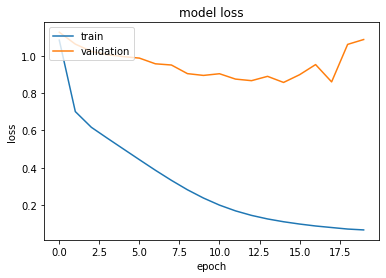

train accuracy: 0.7777777910232544
test accuracy: 0.8888888955116272
  {
   train_paths: ['../Source/Subjects/Az_Mar_05/TFR/lm_vs_li/mne_sample_epochs_train_0.tfrecord'],
   val_paths: [],
   test_paths: ['../Source/Subjects/Az_Mar_05/TFR/lm_vs_li/mne_sample_epochs_test_0.tfrecord'],
   folds: [[array([32, 12,  2, 36,  6, 16, 38, 29,  9]), array([25,  8, 24, 48, 26, 22, 11,  1, 20]), array([44, 43, 45, 52, 56, 55, 18, 21, 34]), array([39, 54, 46, 47, 28,  0, 10, 31, 40]), array([19,  3, 30, 50, 17, 15, 41, 14, 49])]],
   test_fold: [array([53, 23,  4, 51, 35, 27, 33, 42,  7])],
   data_id: mne_sample_epochs,
   train_size: 48,
   val_size: 9,
   test_size: 9,
   savepath: ../Source/Subjects/Az_Mar_05/TFR/lm_vs_li/,
   target_type: int,
   input_type: trials,
   fs: 200,
   class_ratio: {
     0: 0.5263157894736842,
     1: 0.47368421052631576,
    }
   y_shape: (2,),
   n_seq: 1,
   n_t: 200,
   n_ch: 204,
   train_batch: 100,
  }



In [7]:
from utils.console import Silence
import mneflow as mf


# combiner = EpochsCombiner(
#     resp_lock_lm_B1_epochs,
#     resp_lock_li_B1_epochs,
#     resp_lock_rm_B1_epochs,
#     resp_lock_ri_B1_epochs
# ).combine((0, 1), (2, 3), shuffle=True)

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
).combine(0, 1, shuffle=True)


train_cscorer = CrossScorer()
test_cscorer = CrossScorer()

#left vs right
# train accuracy: 0.898947365283966
# test accuracy: 0.8673684167861938
# LI VS LM
# train accuracy: 0.9066666722297668
# test accuracy: 0.800000011920929

with Silence():
    import_opt = dict(
        # path where TFR files will be saved
        savepath='../Source/Subjects/Az_Mar_05/TFR/lm_vs_li/',
        out_name='mne_sample_epochs',  # name of TFRecords files
        fs=200,
        input_type='trials',
        target_type='int',
        picks={'meg': 'grad'},
        scale=True,  # apply baseline_scaling
        crop_baseline=True,  # remove baseline interval after scaling
        decimate=None,
        scale_interval=(0, 60), # indices in time axis corresponding to baseline interval
        n_folds=5,  # validation set size set to 20% of all data
        overwrite=True,
        segment=False,
        test_set='holdout'
    )

    meta = mf.produce_tfrecords((combiner.X, combiner.Y), **import_opt)

    dataset = mf.Dataset(meta, train_batch=100)
    lf_params = dict(
        n_latent=32,
        filter_length=20,
        nonlin=tf.keras.activations.relu, # tf.keras.activations.elu,
        padding='SAME',
        pooling=7,
        stride=7,
        pool_type='max',
        model_path=import_opt['savepath'],
        dropout=0.4,
        l1_scope=["weights"],
        l1=1e-3
    )
    model = mf.models.LFCNN(dataset, lf_params)
    model.build()
    model.train(n_epochs=50, eval_step=100, early_stopping=5)
    
train_loss, train_acc = model.evaluate(meta['train_paths'])
test_loss, test_acc = model.evaluate(meta['test_paths'])
train_cscorer.score = train_acc
test_cscorer.score = test_acc

model.plot_hist()


print(f'train accuracy: {train_cscorer.mean()}\ntest accuracy: {test_cscorer.mean()}')
print(dict2str(meta))
